In [2]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

### Weight block 별 PCA plot

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]
block_size = 16

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for idx in [0, 1, 10, 31]:
        named_linears = get_named_linears(layers[idx])

        for n, m in named_linears.items():

            W = m.weight.data.detach().cpu()
            shape = W.shape

            variants = {
                'original': W,
                'row_norm': W / (W.std(dim=1, keepdim=True) + 1e-6),
                'col_norm': W / (W.std(dim=0, keepdim=True) + 1e-6),
            }

            block_sizes= [8, 16, 64, 128, -1]
            fig, axes = plt.subplots(len(block_sizes), 6, figsize=(24, 4 * len(block_sizes)))
            
            for i, block_size in enumerate(block_sizes):
                pca_results = []
                for name, W_var in variants.items():
                    # reshape for row and col PCA
                    try:
                        bs = block_size if block_size > 0 else shape[1]
                        row_data = W_var.reshape(-1, bs).numpy()
                        row_pca = PCA(n_components=2).fit_transform(row_data)
                    except Exception as e:
                        print(f"[{name}] Row PCA failed: {e}")
                        row_pca = None

                    try:
                        bs = block_size if block_size > 0 else shape[0]
                        col_data = W_var.T.reshape(-1, bs).numpy()
                        col_pca = PCA(n_components=2).fit_transform(col_data)
                    except Exception as e:
                        print(f"[{name}] Col PCA failed: {e}")
                        col_pca = None

                    # 축 범위 맞추기
                    all_valid = [p for p in [row_pca, col_pca] if p is not None]
                    if all_valid:
                        all_concat = np.concatenate(all_valid, axis=0)
                        max_abs = np.abs(all_concat).max()
                    else:
                        max_abs = 1.0

                    pca_results.extend([
                        (f"{name} row PCA", row_pca, max_abs, '#6baed6'),
                        (f"{name} col PCA", col_pca, max_abs, 'orange')
                    ])
                
                # plot
                # axes = axes.flatten()
                axs = axes[i]
                for ax, (title, data, max_abs, color) in zip(axs, pca_results):
                    if data is not None:
                        ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.6, color=color)
                        ax.set_xlim(-max_abs, max_abs)
                        ax.set_ylim(-max_abs, max_abs)
                    ax.set_title(f"{idx}_{n.split('.')[-1]} ({title}) block_size {block_size}")
                    ax.set_xlabel("PC1")
                    ax.set_ylabel("PC2")
                    ax.grid(True)

            plt.suptitle(f"PCA of {model_name} Layer {idx} / {n.split('.')[-1]}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            os.makedirs(f"./plot/pca_compare/{model_name}/{n.split('.')[-1]}", exist_ok=True)
            plt.savefig(f"./plot/pca_compare/{model_name}/{n.split('.')[-1]}/{idx}_{n.split('.')[-1]}.png")
            # plt.show()
            plt.close(fig)

## PCA with MSE

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]

comp_path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Meta-Llama-3-8B/ql_8b/lmbda300'
comp_path2 = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Llama-2-7b-hf/ql_8b_7b_droplast/lmbda300'
n_map = {'q_proj':'q', 'k_proj':'k', 'v_proj':'v', 'o_proj':'o', 'gate_proj':'gate', 'up_proj':'up', 'down_proj':'down'}

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for idx in [1, 10, 31]:
        named_linears = get_named_linears(layers[idx])

        for n, m in named_linears.items():
            W = m.weight.data.detach().cuda()
            
            ckpt_path = os.path.join(comp_path, f"{idx}_{n_map[n.split('.')[-1]]}.pt")
            W_hat = torch.load(ckpt_path, map_location='cuda', weights_only=False)['W_hat']
            
            mse = (W_hat - W)**2
            W = W.cpu()
            W_hat = W_hat.cpu()
                        
            shape = W.shape

            variants = {
                'original': W,
                'row_norm': W / (W.std(dim=1, keepdim=True) + 1e-6),
                'col_norm': W / (W.std(dim=0, keepdim=True) + 1e-6),
            }

            block_sizes= [8, 16, 64, 128, -1]
            # block_sizes= [8, 16]
            fig, axes = plt.subplots(len(block_sizes), 6, figsize=(24, 4 * len(block_sizes)))
            
            for i, block_size in enumerate(block_sizes):
                pca_results = []
                for name, W_var in variants.items():
                    
                    # reshape for row and col PCA
                    bs = block_size if block_size > 0 else shape[1]
                    row_data = W_var.reshape(-1, bs).numpy()
                    row_pca = PCA(n_components=2).fit_transform(row_data)
                    row_mse_block = mse.reshape(-1, bs).mean(dim=1).cpu().numpy()  

                    bs = block_size if block_size > 0 else shape[0]
                    col_data = W_var.T.reshape(-1, bs).numpy()
                    col_pca = PCA(n_components=2).fit_transform(col_data)
                    col_mse_block = mse.T.reshape(-1, bs).mean(dim=1).cpu().numpy()
                    
                    # 축 범위 맞추기
                    all_valid = [p for p in [row_pca, col_pca] if p is not None]
                    if all_valid:
                        all_concat = np.concatenate(all_valid, axis=0)
                        max_abs = np.abs(all_concat).max()
                    else:
                        max_abs = 1.0

                    pca_results.extend([
                        (f"{name} row PCA", row_pca, max_abs, row_mse_block),
                        (f"{name} col PCA", col_pca, max_abs, col_mse_block)
                    ])
                
                # plot
                # axes = axes.flatten()
                axs = axes[i]
                for ax, (title, data, max_abs, errors) in zip(axs, pca_results):
                    if data is not None:
                        sc = ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7, c=errors, cmap='viridis')
                        ax.set_xlim(-max_abs, max_abs)
                        ax.set_ylim(-max_abs, max_abs)
                        plt.colorbar(sc, ax=ax)  # 컬러바 추가
                    ax.set_title(f"{idx}_{n.split('.')[-1]} ({title}) block_size {block_size}")
                    ax.set_xlabel("PC1")
                    ax.set_ylabel("PC2")
                    ax.grid(True)

            plt.suptitle(f"PCA of {model_name} Layer {idx} / {n.split('.')[-1]}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            os.makedirs(f"./plot/pca_mse/{model_name}/{n.split('.')[-1]}", exist_ok=True)
            plt.savefig(f"./plot/pca_mse/{model_name}/{n.split('.')[-1]}/{idx}_{n.split('.')[-1]}.png")
            plt.show()
            plt.close(fig)

# PCA scaleH
original rnorm, cnorm

In [3]:
wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}
sigma_reg = 1e-4

def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


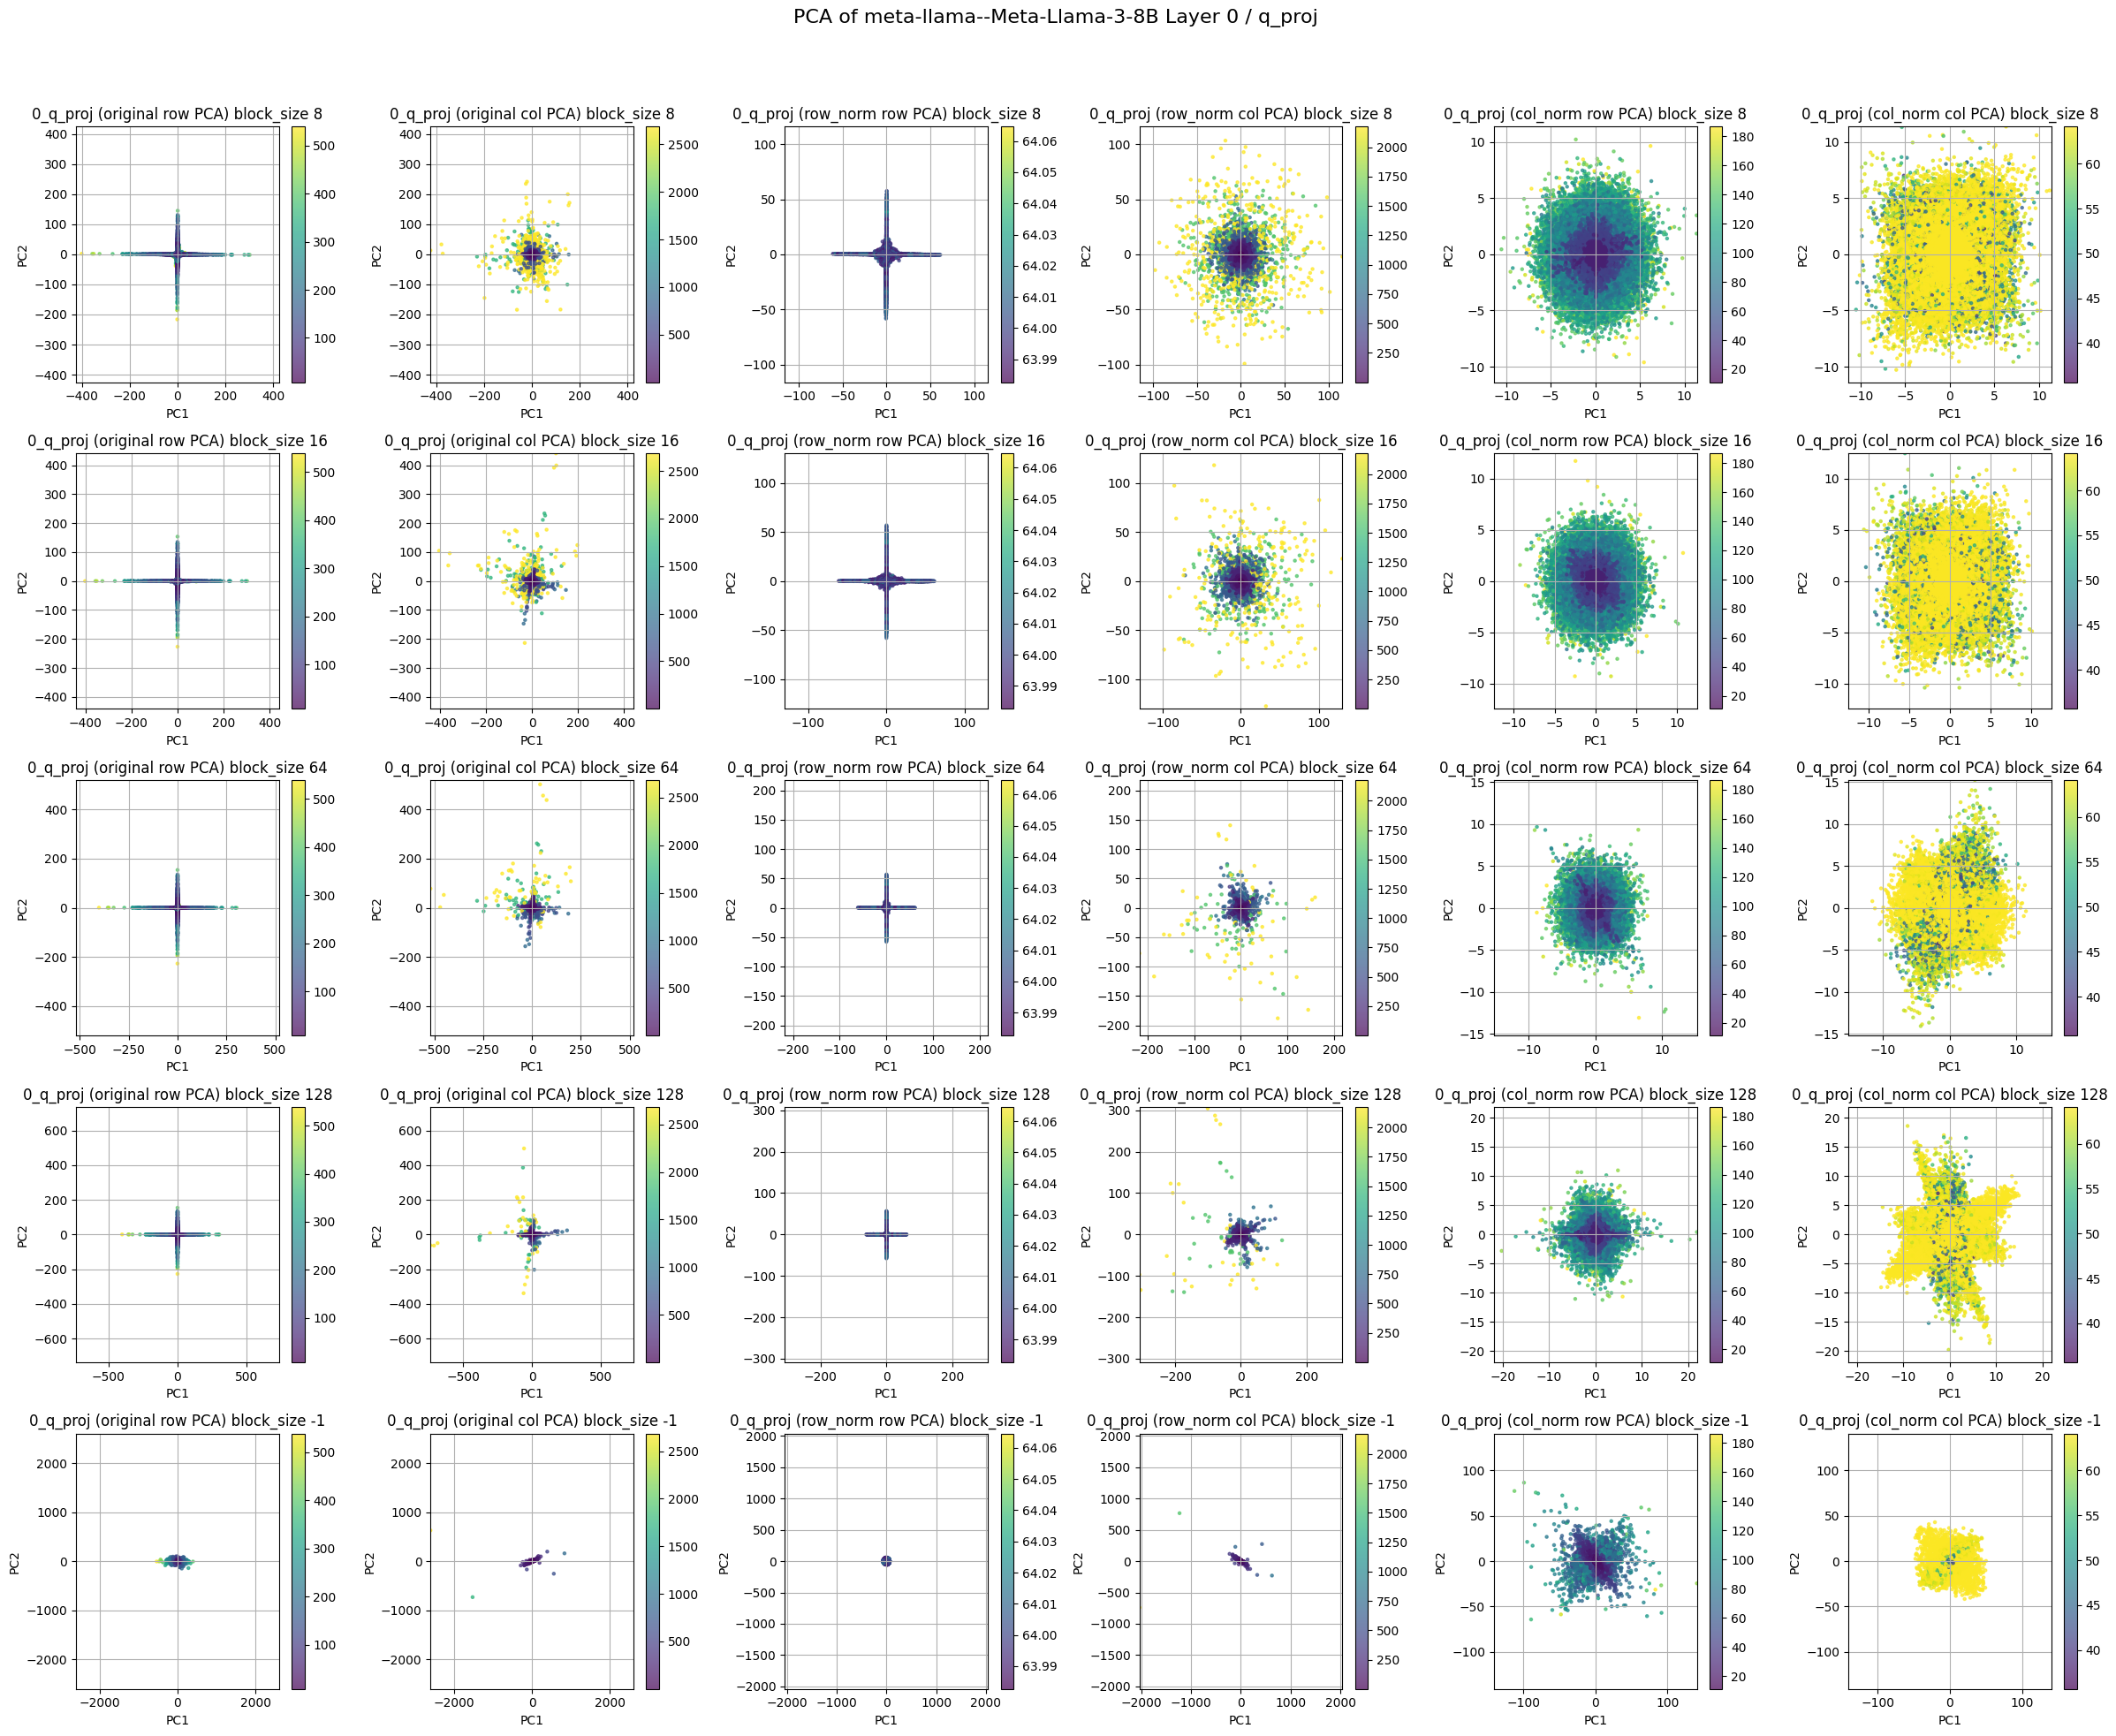

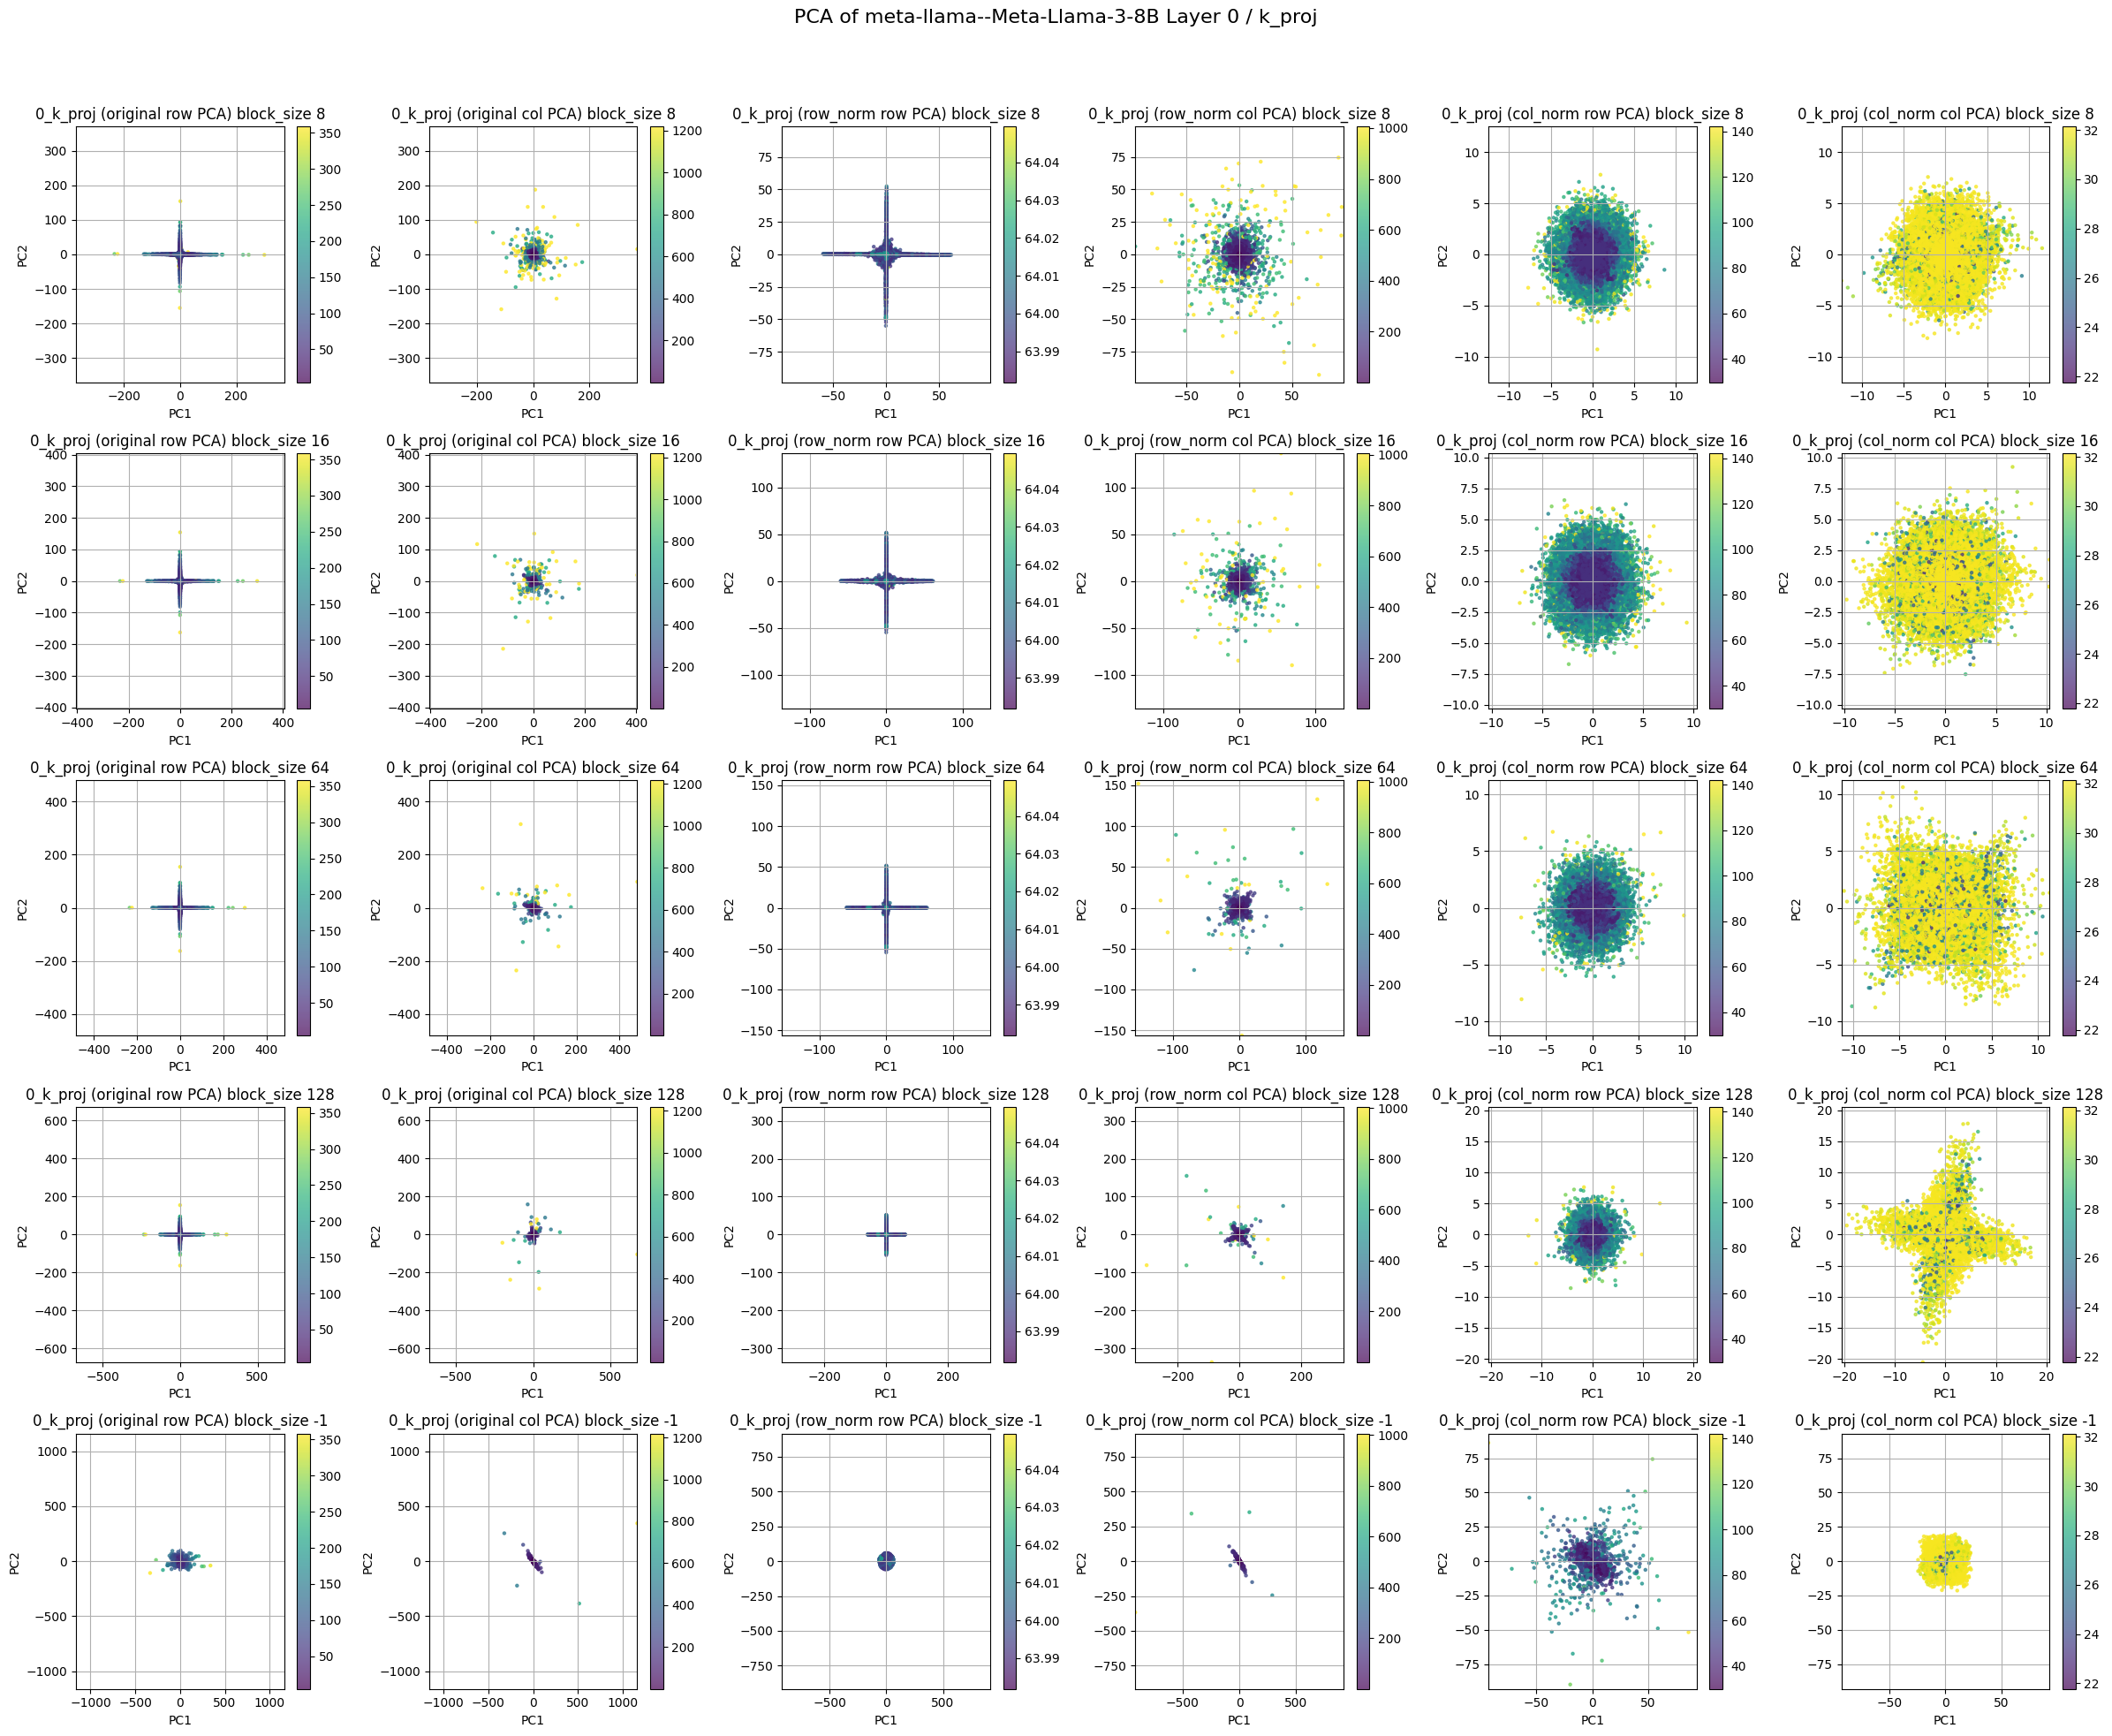

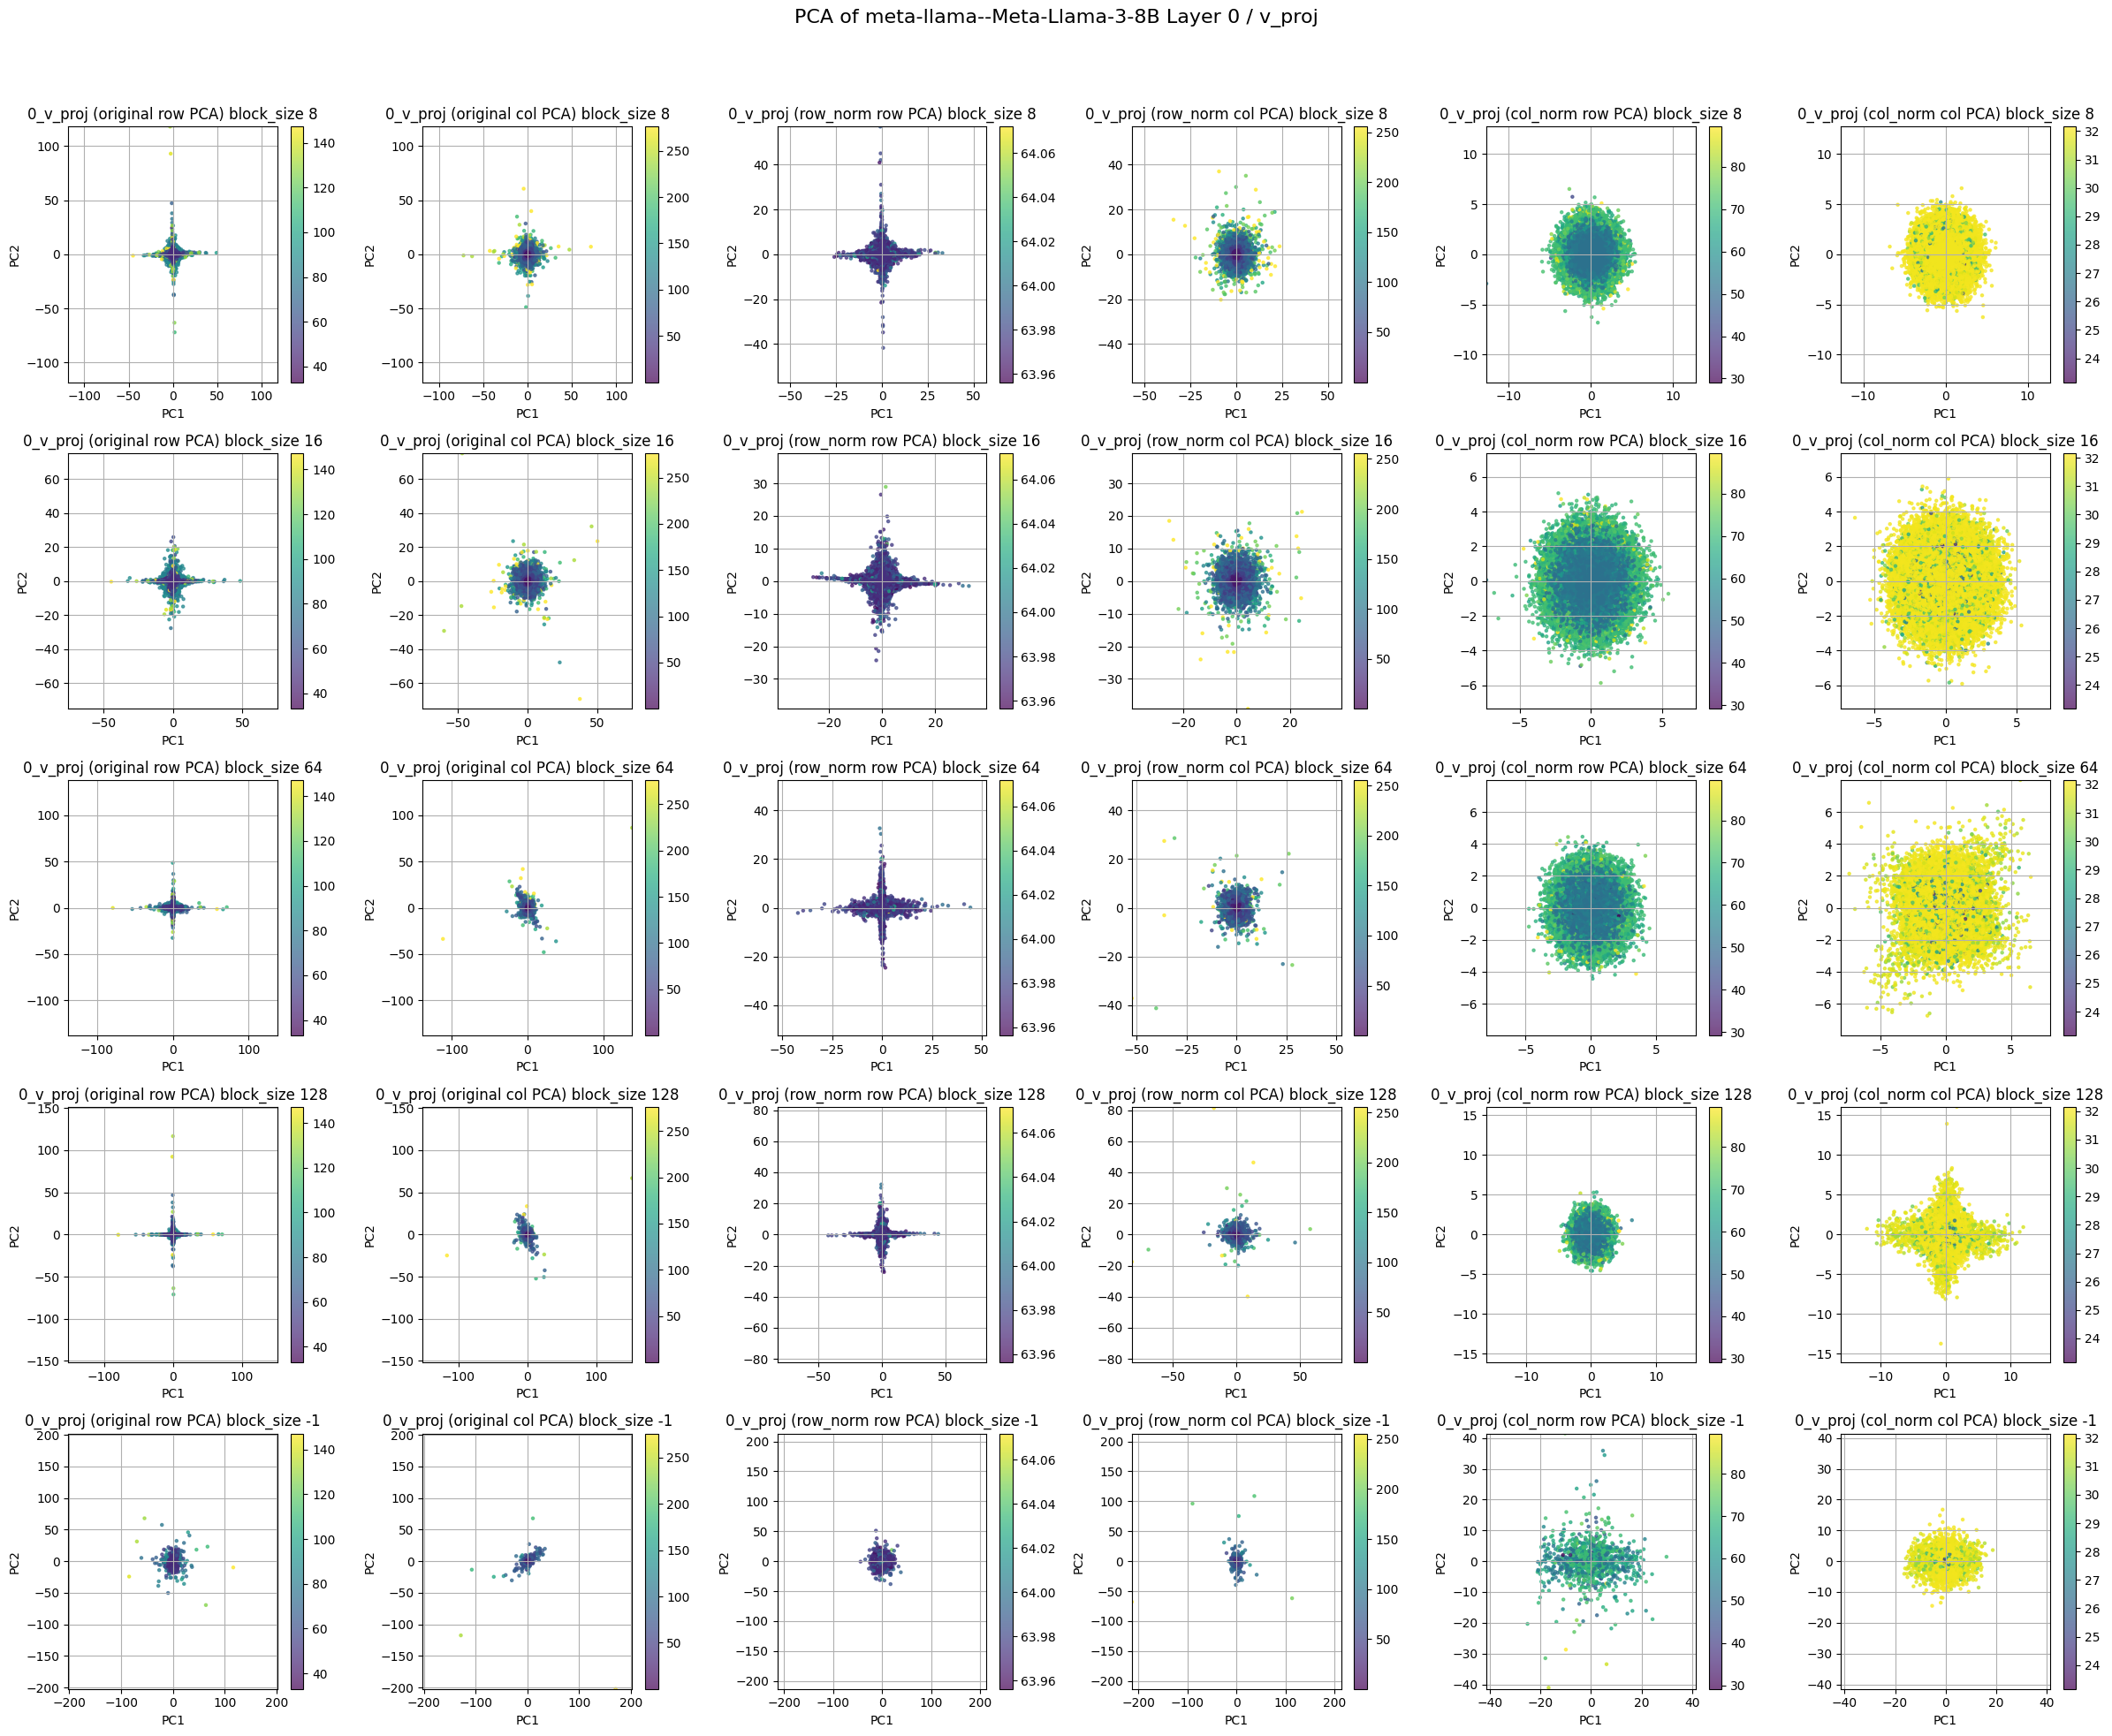

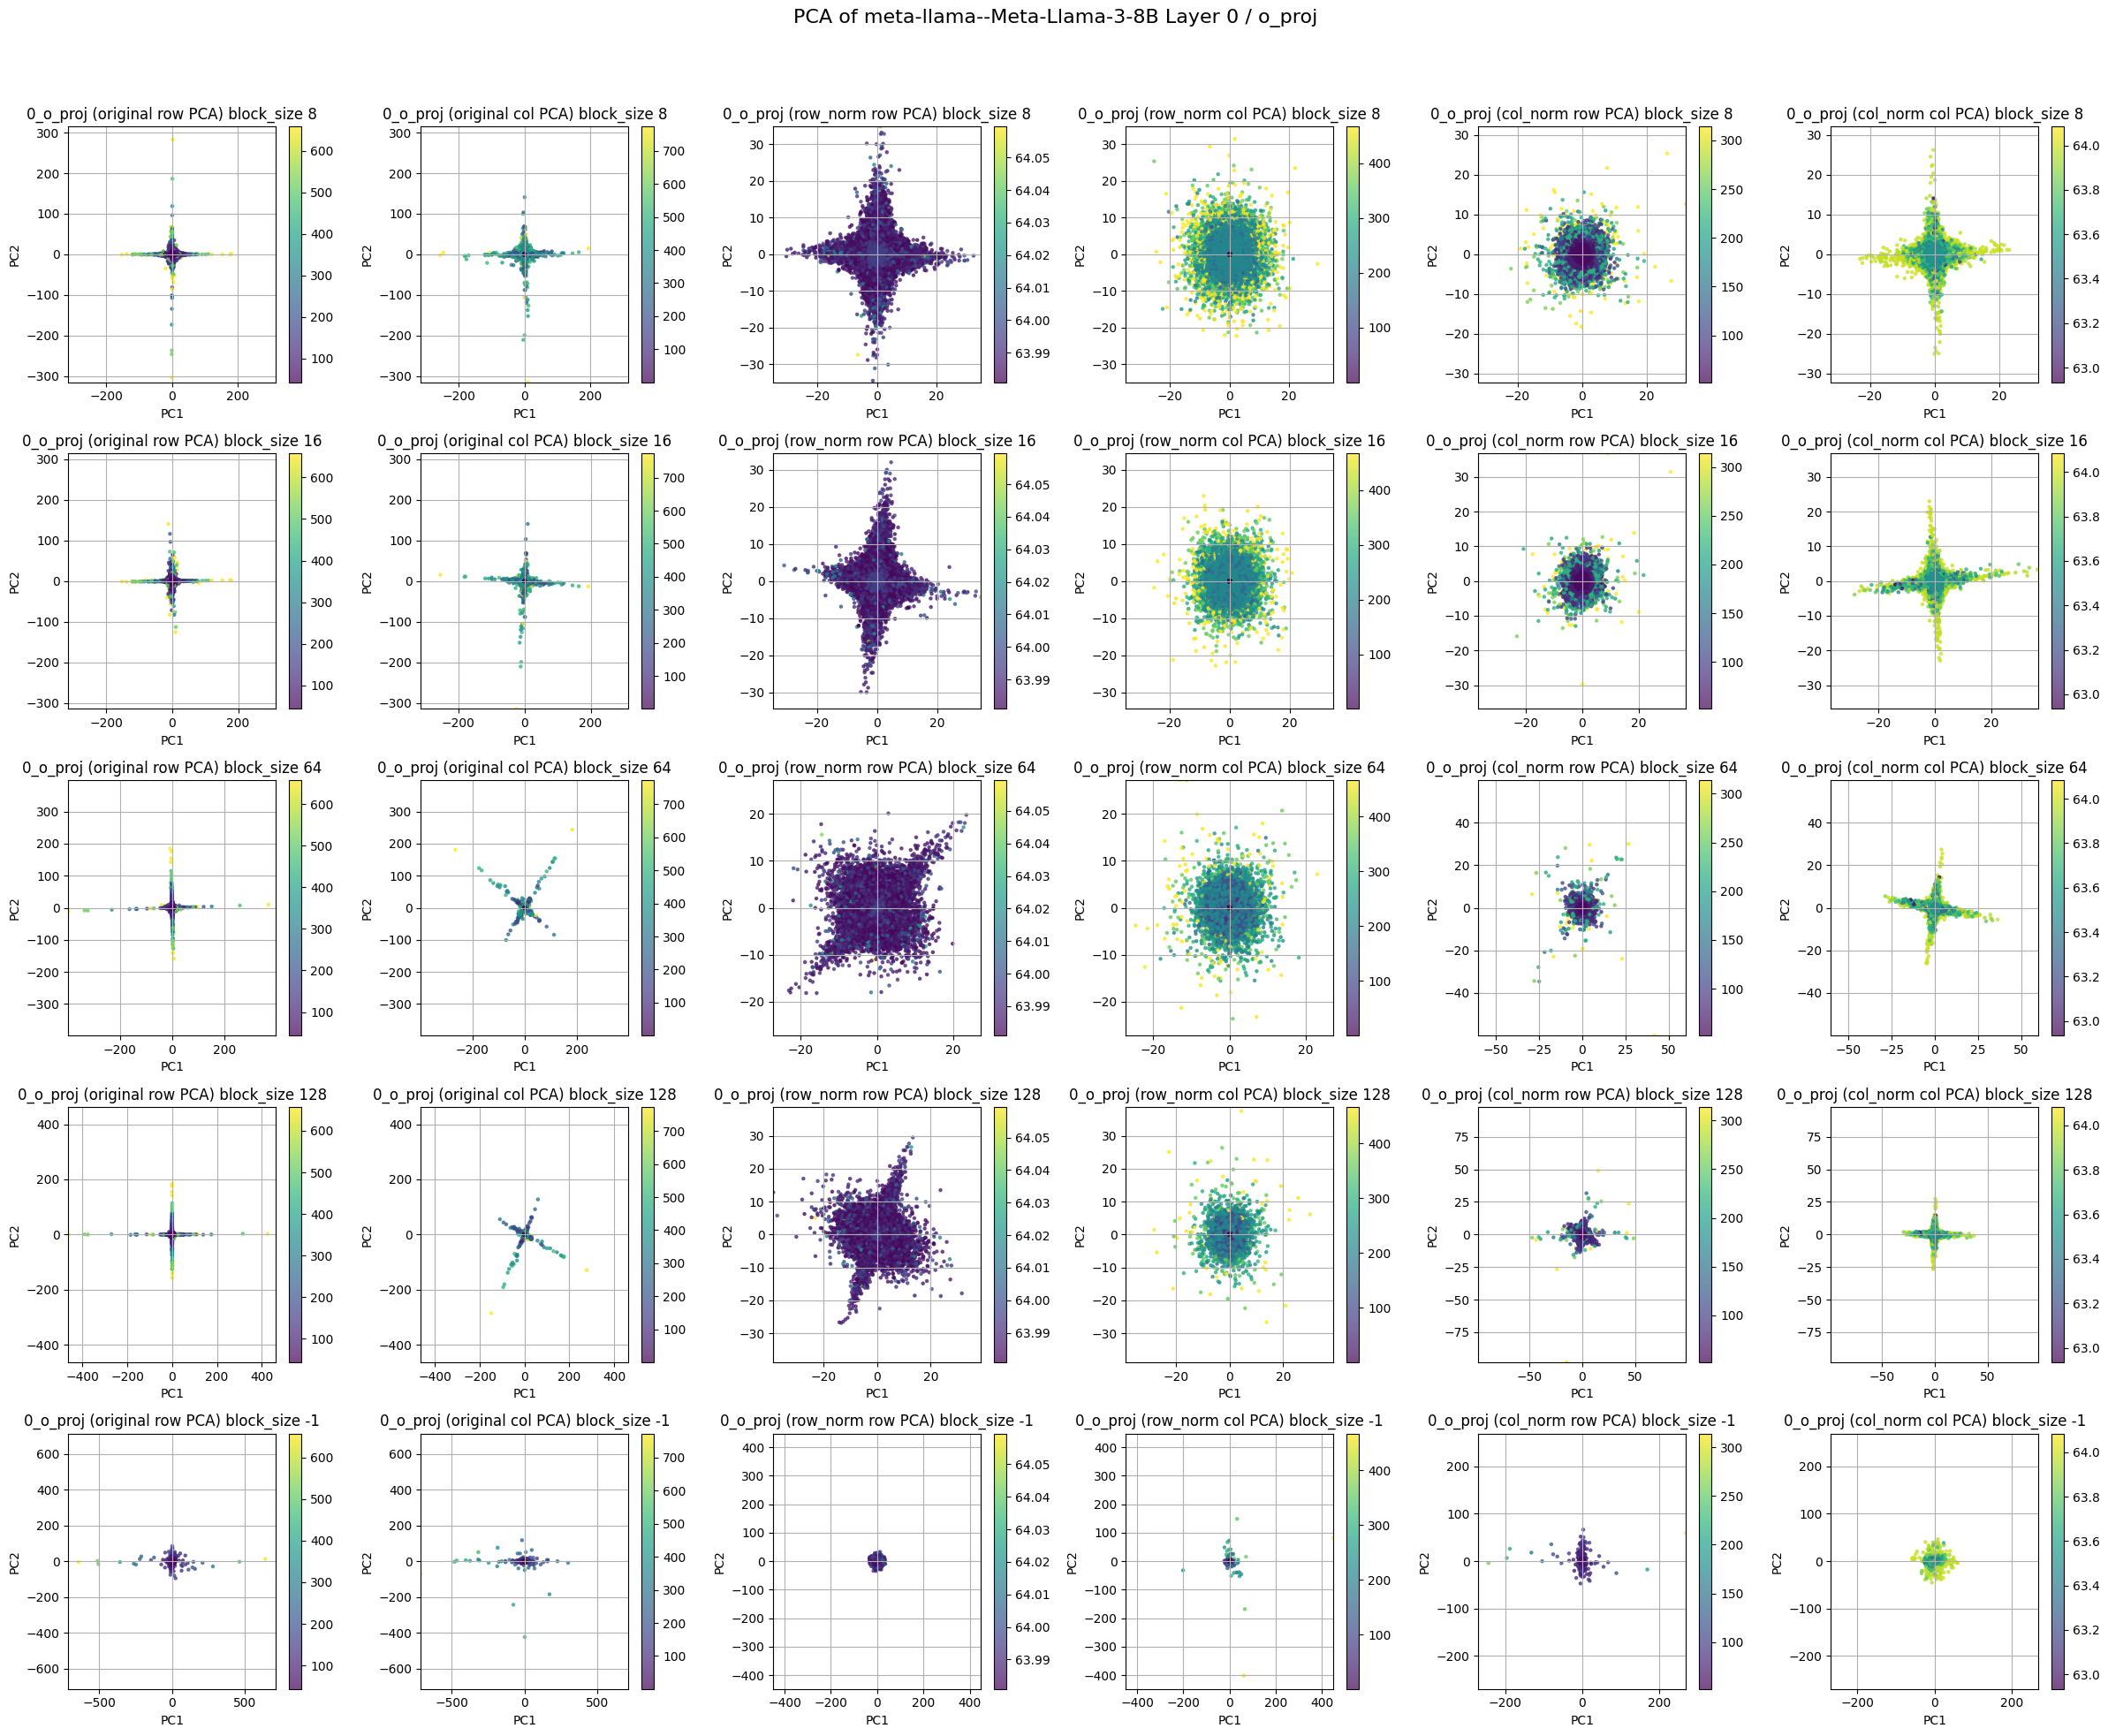

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]

# comp_path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Meta-Llama-3-8B/ql_8b/lmbda300'
# comp_path2 = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Llama-2-7b-hf/ql_8b_7b_droplast/lmbda300'
n_map = {'q_proj':'q', 'k_proj':'k', 'v_proj':'v', 'o_proj':'o', 'gate_proj':'gate', 'up_proj':'up', 'down_proj':'down'}

quip_hess_path = [
    # './quip_hess/Hessians-Llama-2-7b-6144',
    './quip_hess/llama3_8b_6144',
]

# device = torch.device("cuda:3")
# device = torch.device("cpu")

for model_name, quip_hess in zip(model_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for idx in [0, 1, 10, 31]:
        named_linears = get_named_linears(layers[idx])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{idx}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{idx}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{idx}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{idx}_down.pt', weights_only=False)

        for n, m in named_linears.items():
            W = m.weight.data.detach().cuda()
            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).cuda()
            mu = H_flat['mu'].cuda()
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            scaleWH = diagH.sqrt()
            Wr = W * scaleWH[None, :]
            # W_normalized = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            # W_normalized = Wr / Wr.std(dim=1, keepdim=True)
            # W = W_normalized            
            
            # print('after',torch.diag(H).mean())
            
            # ckpt_path = os.path.join(comp_path, f"{idx}_{n_map[n.split('.')[-1]]}.pt")
            # W_hat = torch.load(ckpt_path, map_location='cuda', weights_only=False)['W_hat']
            
            # mse = (W_hat - W)**2
            # W_hat = W_hat.cpu()
            # r_std = Wr.std(dim=1, keepdim=True)
            W = Wr
                        
            shape = W.shape

            # variants = {
            #     'original': W,
            #     # 'row_norm': W / (W.std(dim=1, keepdim=True) + 1e-6),
            #     # 'col_norm': W / (W.std(dim=0, keepdim=True) + 1e-6),
            # }
            
            variants = {
                'original': W / (W.std() + 1e-6),
                'row_norm': W / (W.std(dim=1, keepdim=True) + 1e-6),
                'col_norm': W / (W.std(dim=0, keepdim=True) + 1e-6),
            }
            
            norms = {}
            for name, W_var in variants.items():
                norms[name] = {'rnorm': W_var.norm(p=2, dim=1, keepdim=True), 
                               'cnrom': W_var.norm(p=2, dim=0, keepdim=True)}
            
            
            block_sizes= [8, 16, 64, 128, -1]
            # block_sizes= [8, 16]
            fig, axes = plt.subplots(len(block_sizes), 6, figsize=(24, 4 * len(block_sizes)))
            
            for i, block_size in enumerate(block_sizes):
                pca_results = []
                for name, W_var in variants.items():
                    
                    # reshape for row and col PCA
                    bs = block_size if block_size > 0 else shape[1]
                    row_data = W_var.reshape(-1, bs).cpu().numpy()
                    row_pca = PCA(n_components=2).fit_transform(row_data)
                    # row_std_block = (W_var.reshape(-1, bs).norm(p=2, dim=1)*torch.sqrt(bs)).cpu().numpy()  
                    # row_mse_block = mse.reshape(-1, bs).mean(dim=1).cpu().numpy()
                    row_norm = norms[name]['rnorm'].repeat(1, W_var.shape[1]//bs).reshape(-1 ).cpu().numpy()
                    
                    bs = block_size if block_size > 0 else shape[0]
                    col_data = W_var.T.reshape(-1, bs).cpu().numpy()
                    col_pca = PCA(n_components=2).fit_transform(col_data)
                    # col_mse_block = mse.T.reshape(-1, bs).mean(dim=1).cpu().numpy()
                    # col_std_block = (W_var.T.reshape(-1, bs).norm(p=2, dim=1)*torch.sqrt(bs)).cpu().numpy()  
                    col_norm = norms[name]['cnrom'].repeat(W_var.shape[0]//bs, 1).T.reshape(-1 ).cpu().numpy()            
                    
                    # 축 범위 맞추기
                    all_valid = [p for p in [row_pca, col_pca] if p is not None]
                    if all_valid:
                        all_concat = np.concatenate(all_valid, axis=0)
                        max_abs = np.abs(all_concat).max()
                    else:
                        max_abs = 1.0

                    pca_results.extend([
                        (f"{name} row PCA", row_pca, max_abs, row_norm),
                        (f"{name} col PCA", col_pca, max_abs, col_norm)
                    ])
                
                # plot
                # axes = axes.flatten()
                axs = axes[i]
                for ax, (title, data, max_abs, errors) in zip(axs, pca_results):
                    if data is not None:
                        sc = ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7, c=errors, cmap='viridis')
                        # sc = ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7)
                        ax.set_xlim(-max_abs, max_abs)
                        ax.set_ylim(-max_abs, max_abs)
                        plt.colorbar(sc, ax=ax)  # 컬러바 추가
                    ax.set_title(f"{idx}_{n.split('.')[-1]} ({title}) block_size {block_size}")
                    ax.set_xlabel("PC1")
                    ax.set_ylabel("PC2")
                    ax.grid(True)

            plt.suptitle(f"PCA of {model_name} Layer {idx} / {n.split('.')[-1]}", fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            os.makedirs(f"./plot/pca_scaleh_vector_norm_colarbar/{model_name}/{n.split('.')[-1]}", exist_ok=True)
            plt.savefig(f"./plot/pca_scaleh_vector_norm_colarbar/{model_name}/{n.split('.')[-1]}/{idx}_{n.split('.')[-1]}.png")
            plt.show()
            plt.close(fig)

In [ ]:
named_linears.keys()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

model_list = [
    'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]

block_size = 16

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)    

    for idx in [0, 1, 10, 31]:
        named_linears = get_named_linears(layers[idx])
        
        for (n, m) in zip(named_linears.items()):
            W = m.weight.data.detach()
            shape = W.shape

            # # 정규분포 기반 residual 생성
            # W_flat = W.flatten()
            # mu = W_flat.mean().item()
            # sigma = W_flat.std(unbiased=False).item()
            # fitted = torch.tensor(norm(loc=mu, scale=sigma).rvs(size=W_flat.numel()))
            # residual = (W_flat - fitted).reshape(shape)

            # PCA 계산
            row_pca, col_pca = None, None
            try:
                bs = block_size if block_size > 0 else shape[1]
                pca_row = PCA(n_components=2)
                row_pca = pca_row.fit_transform(W.reshape(-1, bs).cpu())
            except Exception as e:
                print(f"[Row PCA] {n} failed: {e}")

            try:
                bs = block_size if block_size > 0 else shape[0]
                pca_col = PCA(n_components=2)
                col_pca = pca_col.fit_transform(W.T.reshape(-1, block_size).cpu())
            except Exception as e:
                print(f"[Col PCA] {n} failed: {e}")

            # x, y 동일한 범위로 설정
            all_pca = []
            if row_pca is not None:                all_pca.append(row_pca)
            if col_pca is not None:                all_pca.append(col_pca)
            all_concat = np.concatenate(all_pca, axis=0)
            max_abs = np.abs(all_concat).max()

            fig, axes = plt.subplots(4, 2, figsize=(10, 5 * 4))

            # Row PCA plot
            if row_pca is not None:
                ax_row.scatter(row_pca[:, 0], row_pca[:, 1], s=5, alpha=0.6)
                ax_row.set_title(f"{idx}_{n.split('.')[-1]} (Row PCA block_size={block_size})")
                ax_row.set_xlim(-max_abs, max_abs)
                ax_row.set_ylim(-max_abs, max_abs)
                ax_row.set_xlabel("PC1")
                ax_row.set_ylabel("PC2")
                ax_row.grid(True)
            else:
                ax_row.set_title(f"{idx}_{n} (Row PCA failed)")

            # Column PCA plot
            if col_pca is not None:
                ax_col.scatter(col_pca[:, 0], col_pca[:, 1], s=5, alpha=0.6, color='orange')
                ax_col.set_title(f"{idx}_{n.split('.')[-1]} (Column PCA block_size={block_size})")
                ax_col.set_xlim(-max_abs, max_abs)
                ax_col.set_ylim(-max_abs, max_abs)
                ax_col.set_xlabel("PC1")
                ax_col.set_ylabel("PC2")
                ax_col.grid(True)
            else:
                ax_col.set_title(f"{idx}_{n} (Col PCA failed)")

            plt.suptitle(f"PCA of Residual Vectors (Layer {idx})", fontsize=18)
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            os.makedirs(f"./plot/pca_residual/{model_name}", exist_ok=True)
            plt.savefig(f"./plot/pca_residual/{model_name}/{idx}_{n.split('.')[-1]}_block_size{block_size}.png")
            plt.show()
            plt.close(fig)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM

model_list = [
    'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]

block_size = 128

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)    

    for idx in [0, 1, 10, 31]:  # 하나의 레이어만 예시
        named_linears = get_named_linears(layers[idx])
        num_layers = len(named_linears)
        fig, axes = plt.subplots(num_layers, 2, figsize=(10, 10 * num_layers))

        for (n, m), (ax_row, ax_col) in zip(named_linears.items(), axes):
            W = m.weight.data.detach()
            shape = W.shape

            # 정규분포 기반 residual 생성
            W_flat = W.flatten()
            mu = W_flat.mean().item()
            sigma = W_flat.std(unbiased=False).item()
            fitted = torch.tensor(norm(loc=mu, scale=sigma).rvs(size=W_flat.numel()))
            residual = (W_flat - fitted).reshape(shape)
            residual_blockwise = residual.reshape(-1, block_size)

            # Row-wise PCA
            try:
                pca_row = PCA(n_components=2)
                # row_pca = pca_row.fit_transform(residual_blockwise.cpu())
                row_pca = pca_row.fit_transform(W.cpu())
                ax_row.scatter(row_pca[:, 0], row_pca[:, 1], s=5, alpha=0.6)
                ax_row.set_title(f"{idx}_{n} (Row PCA)")
                ax_row.set_xlabel("PC1")
                ax_row.set_ylabel("PC2")
                ax_row.grid(True)
            except Exception as e:
                ax_row.set_title(f"{idx}_{n} (Row PCA failed)")
                print(f"[Row PCA] {n} failed: {e}")

            # Column-wise PCA
            residual_blockwise = residual.T.reshape(-1, block_size)
            try:
                pca_col = PCA(n_components=2)
                # col_pca = pca_col.fit_transform(residual_blockwise.cpu())  # transpose
                col_pca = pca_col.fit_transform(W.T.cpu())  # transpose
                ax_col.scatter(col_pca[:, 0], col_pca[:, 1], s=5, alpha=0.6, color='orange')
                ax_col.set_title(f"{idx}_{n} (Column PCA)")
                ax_col.set_xlabel("PC1")
                ax_col.set_ylabel("PC2")
                ax_col.grid(True)
            except Exception as e:
                ax_col.set_title(f"{idx}_{n} (Col PCA failed)")
                print(f"[Col PCA] {n} failed: {e}")

        plt.suptitle(f"PCA of Residual Vectors (Layer {idx})", fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        os.makedirs(f"./plot/pca_residual/{model_name}", exist_ok=True)
        # plt.savefig(f"./plot/pca_residual/{model_name}/{idx}.png")
        plt.show()
        plt.close(fig)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM

model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama--Llama-2-7b-hf',
]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)    

    for idx in [0]:  # 하나의 레이어만 예시
        named_linears = get_named_linears(layers[idx])
        num_plots = len(named_linears)
        cols = 3
        rows = (num_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

        for ax, (n, m) in zip(axes.flat, named_linears.items()):
            W = m.weight.data.detach()
            shape = W.shape

            W_flat = W.flatten()
            mu = W_flat.mean().item()
            sigma = W_flat.std(unbiased=False).item()
            fitted = torch.tensor(norm(loc=mu, scale=sigma).rvs(size=W_flat.numel()))
            residual = W_flat - fitted
            residual = residual.reshape(shape)

            # PCA: row 기준
            try:
                pca = PCA(n_components=2)
                W_pca = pca.fit_transform(residual.cpu())
                ax.scatter(W_pca[:, 0], W_pca[:, 1], s=5, alpha=0.6)
                ax.set_title(f"{idx}_{n}")
                ax.set_xlabel("PC1")
                ax.set_ylabel("PC2")
                ax.grid(True)
            except Exception as e:
                ax.set_title(f"{idx}_{n} (PCA failed)")
                print(f"Warning: PCA failed for {n}, shape={shape}, error={e}")

        # 빈 subplot 처리
        for ax in axes.flat[num_plots:]:
            ax.axis('off')

        plt.suptitle(f"PCA of Residual Row Vectors (Layer {idx})", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
            
            # group_size = 256  # 또는 128
            # num_groups = W.shape[0] * (W.shape[1] // group_size)
            # residuals_all = []
            # for row in W:
            #     for i in range(0, W.shape[1], group_size):
            #         group = row[i:i+group_size]
            #         if group.numel() != group_size:
            #             continue  # 마지막 잘리는 경우 skip
            #         # 정규분포 피팅 (MLE)
            #         mu = group.mean().item()
            #         sigma = group.std(unbiased=False).item()
            #         # Gaussian 값 생성
            #         fitted = torch.tensor(norm(loc=mu, scale=sigma).rvs(size=group_size))
            #         # 잔차 계산
            #         residual = group - fitted
            #         residuals_all.append(residual.numpy())
            # # 모든 residual flatten
            # residuals_all = np.concatenate(residuals_all)

            # 시각화
            # plt.figure(figsize=(8, 4))
            # sns.histplot(residual, kde=False, bins=1000, color='skyblue')
            # plt.title(f"{idx}_{n}, Residual Distribution after Gaussian Fit")
            # plt.xlabel("Residual")
            # plt.ylabel("Frequency")
            # plt.grid(True)
            # plt.tight_layout()
            # plt.show()
            
            